In [417]:
import pandas as pd
import glob
import os
import re
import networkx as nx
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2
import community.community_louvain
import community
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import seaborn as sb

In [347]:
# remove later
marinas_path = '/Users/mep/Desktop/mep/SocialGraphs/FriendsSentimentAnalysis/scripts'

In [348]:
# remove later
# stella add your path here!!
stellas_path = r'C:\Users\stykaly\OneDrive - DFDS\Documents\GitHub\FriendsSentimentAnalysis\scripts'

In [349]:
# change according to who's working
episodes_path = marinas_path

In [350]:
#input each apisode into a list of str , returns dictionary with episode no as key and script string a value
def make_season_dictionary(episodes_path):
    season_episodes={}
    list_of_episodes = os.listdir( episodes_path)
    for episode in range(228):  # ONLY FOR 1ST SEASON!!
        text_file = open(episodes_path+"/"+list_of_episodes[episode], "r",encoding='utf8')
        episode_script = text_file.read()
        text_file.close()
        season_episodes['{}'.format(f'episode{episode}')]=episode_script
    return season_episodes
    #print(season_episodes)
    
season_dictionary=make_season_dictionary(episodes_path)


In [351]:
#takes a str and splits on Scene, returns list of scenes
def split_episode_scenes(episode_script):
    scenes_of_episode = re.split(r'\[Scene:',episode_script)
    return scenes_of_episode


# takes list as input and extracts list of locations
def locations_finder(scenes_of_episode):
    location_list = []
    for scene in range(1,len(scenes_of_episode)):
        scenes_of_episode[scene]= re.sub(r';',r',',  scenes_of_episode[scene])
        scenes_of_episode[scene]= scenes_of_episode[scene].lower()
        scenes_of_episode[scene]= re.sub(r'rach',r'rachel',  scenes_of_episode[scene])
        scenes_of_episode[scene]= re.sub(r'mnca',r'monica',  scenes_of_episode[scene])
        scenes_of_episode[scene]= re.sub(r'chan',r'chandler',  scenes_of_episode[scene])
        scenes_of_episode[scene]= re.sub(r'phoe',r'phoebe',  scenes_of_episode[scene])
        scenes_of_episode[scene]= re.sub(r'phoebebe',r'phoebe',  scenes_of_episode[scene])
        scenes_of_episode[scene]= re.sub(r'estl',r'estelle',  scenes_of_episode[scene])
        scenes_of_episode[scene]= re.sub(r'rachelel',r'rachel',  scenes_of_episode[scene])
        scenes_of_episode[scene]= re.sub(r'chandlerdler',r'chandler',  scenes_of_episode[scene])
        location = scenes_of_episode[scene].partition(",")[0]
        location_list.append(location)
    return location_list

#takes list as input and extracts list of lists of names of characters, removes duplicates
def character_finder(scenes_of_episode):
    characters_of_scene_list = []
    for scene in range(1,len(scenes_of_episode)):
        character= re.findall('\n[a-zA-Z]+\:',scenes_of_episode[scene])
        for i in range (len(character)):
            character[i] = re.sub(r'\n',r'',character[i])
            character[i] = re.sub(r':',r'',character[i])
        characters_of_scene_list.append(character)
    for scene in range (len(characters_of_scene_list)):
        characters_of_scene_list[scene]= list(dict.fromkeys(characters_of_scene_list[scene]))
    return characters_of_scene_list


In [352]:
##creates a nested dictionary with episodes as keys and a dictionary with scenes as keys and text, location, characters as values
episode_dictionary={}
for episode in list(season_dictionary.keys()):
    list_of_scenes=split_episode_scenes(season_dictionary[episode])
    locations_list=locations_finder(list_of_scenes)
    character_lists=character_finder(list_of_scenes)
    episode_dictionary['{}'.format(episode)]={}
    for i in range (len(list_of_scenes)-1):
        episode_dictionary['{}'.format(episode)]['{}'.format(f'scene{i}')]={}
        episode_dictionary['{}'.format(episode)]['{}'.format(f'scene{i}')]['text']=list_of_scenes[i+1]
        episode_dictionary['{}'.format(episode)]['{}'.format(f'scene{i}')]['location']=locations_list[i]
        episode_dictionary['{}'.format(episode)]['{}'.format(f'scene{i}')]['characters']=character_lists[i]
   
      

In [353]:
#creates a dataframe out of the episodes_dictionary
our_dataframe=pd.concat({
        k: pd.DataFrame.from_dict(v, 'index') for k, v in episode_dictionary.items()
    }, 
    axis=0)
our_dataframe

text  \
episode0   scene0    ross' apartment , chandler and joey enter]\n\...   
           scene1    joey and rachel's apartment]\n\nrachel: hey! ...   
           scene2    central perk]\n\nphoebe: hi.\n\nmonica: hey p...   
           scene3    rachel's room. rachel and emma are sleeping, ...   
           scene4    monica and chandler's. chandler is looking at...   
...                                                               ...   
episode227 scene16   carol's room, she is ready to give birth. eve...   
           scene17   the broom closet, ross has used a broom to op...   
           scene18   carol's room, ross and susan rush in.]\n\nall...   
           scene19   the delivery room, carol is holding the infan...   
           scene20   the hospital, the camera is placed as though ...   

                                                             location  \
episode0   scene0                                    ross' apartment    
           scene1    joey and rachel's apartment]\n\nrachel: hey! ...   
           scene2    central perk]\n\nphoebe: hi.\n\nmonica: hey p...   
           scene3         rachel's room. rachel and emma are sleeping   
           scene4    monica and chandler's. chandler is looking at...   
...                                                               ...   
episode227 scene16                                       carol's room   
           scene17                                   the broom closet   
           scene18                                       carol's room   
           scene19                                  the delivery room   
           scene20                                       the hospital   

                                                           characters  
episode0   scene0                              [chandler, ross, joey]  
           scene1                                      [rachel, joey]  
           scene2                    [phoebe, monica, chandler, ross]  
           scene3                                      [joey, rachel]  
           scene4                            [monica, chandler, ross]  
...                                                               ...  
episode227 scene16     [carol, monica, rachel, joey, chandler, nurse]  
           scene17                     [ross, phoebe, susan, janitor]  
           scene18  [all, ross, carol, nurse, chandler, susan, pho...  
           scene19  [susan, ross, carol, monica, phoebe, rachel, c...  
           scene20  [ross, chandler, monica, rachel, joey, phoebe,...  

[3050 rows x 3 columns]

In [354]:
our_dataframe.to_csv('Friends_dataframe.csv', index=True)

In [355]:
## sorts characters alphabetically in the dataframe
for item in our_dataframe['characters']:
    item=item.sort()

In [356]:
# Creates dataframe with all the links
df_links = pd.DataFrame(columns=['nodes','node1-node2'])
for i in range(len(our_dataframe['characters'])):
    for j in range(len(our_dataframe['characters'][i])-1):
        for k in range(j,len(our_dataframe['characters'][i])-1):
             df_links.loc[len(df_links.index)] = [[our_dataframe['characters'][i][j], our_dataframe['characters'][i][k+1]],our_dataframe['characters'][i][j] + '-'+ our_dataframe['characters'][i][k+1]]

In [357]:
##Creates a df with the edges and their weights
##When this cell runs it produces a warning, IGNORE it and wait a bit to see the dataframe

#counts how many times 2 characters are linked in df_links and adds it to weights_dict
weights_dict=Counter(df_links['node1-node2'])

#Creates the intersection_df which has the edges and their weight as dataframe
df_weights = pd.DataFrame(list(weights_dict.items()), columns = ['node1-node2','weight'])
intersection_df = pd.merge(df_weights,df_links, how='inner', on=['node1-node2'])

#removes duplicates and resets the index
intersection_df =intersection_df.drop_duplicates(subset='node1-node2', keep='first')
intersection_df = intersection_df.reset_index(drop=True)

#create 2 separate columns for each node
intersection_df['node1'] = intersection_df.apply(lambda _: '', axis=1)
intersection_df['node2'] = intersection_df.apply(lambda _: '', axis=1)

#adds the character that are linked in these columns
for i in range (len(intersection_df['node1-node2'])):
    intersection_df['node1'][i]=intersection_df['nodes'][i][0]
    intersection_df['node2'][i]=intersection_df['nodes'][i][1]
intersection_df

/var/folders/3f/gy6lrkwn0c19wnb7_h2c682c0000gr/T/ipykernel_72127/3616919215.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intersection_df['node1'][i]=intersection_df['nodes'][i][0]
/var/folders/3f/gy6lrkwn0c19wnb7_h2c682c0000gr/T/ipykernel_72127/3616919215.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intersection_df['node2'][i]=intersection_df['nodes'][i][1]


,node1-node2,weight,nodes,node1,node2
0,chandler-joey,899,"[chandler, joey]",chandler,joey
1,chandler-ross,728,"[chandler, ross]",chandler,ross
2,joey-ross,701,"[joey, ross]",joey,ross
3,joey-rachel,711,"[joey, rachel]",joey,rachel
4,chandler-monica,950,"[chandler, monica]",chandler,monica
...,...,...,...,...,...
1797,carol-nurse,2,"[carol, nurse]",carol,nurse
1798,janitor-phoebe,1,"[janitor, phoebe]",janitor,phoebe
1799,janitor-susan,1,"[janitor, susan]",janitor,susan
1800,all-nurse,1,"[all, nurse]",all,nurse


Text(0.5, 1.0, 'all seasons')

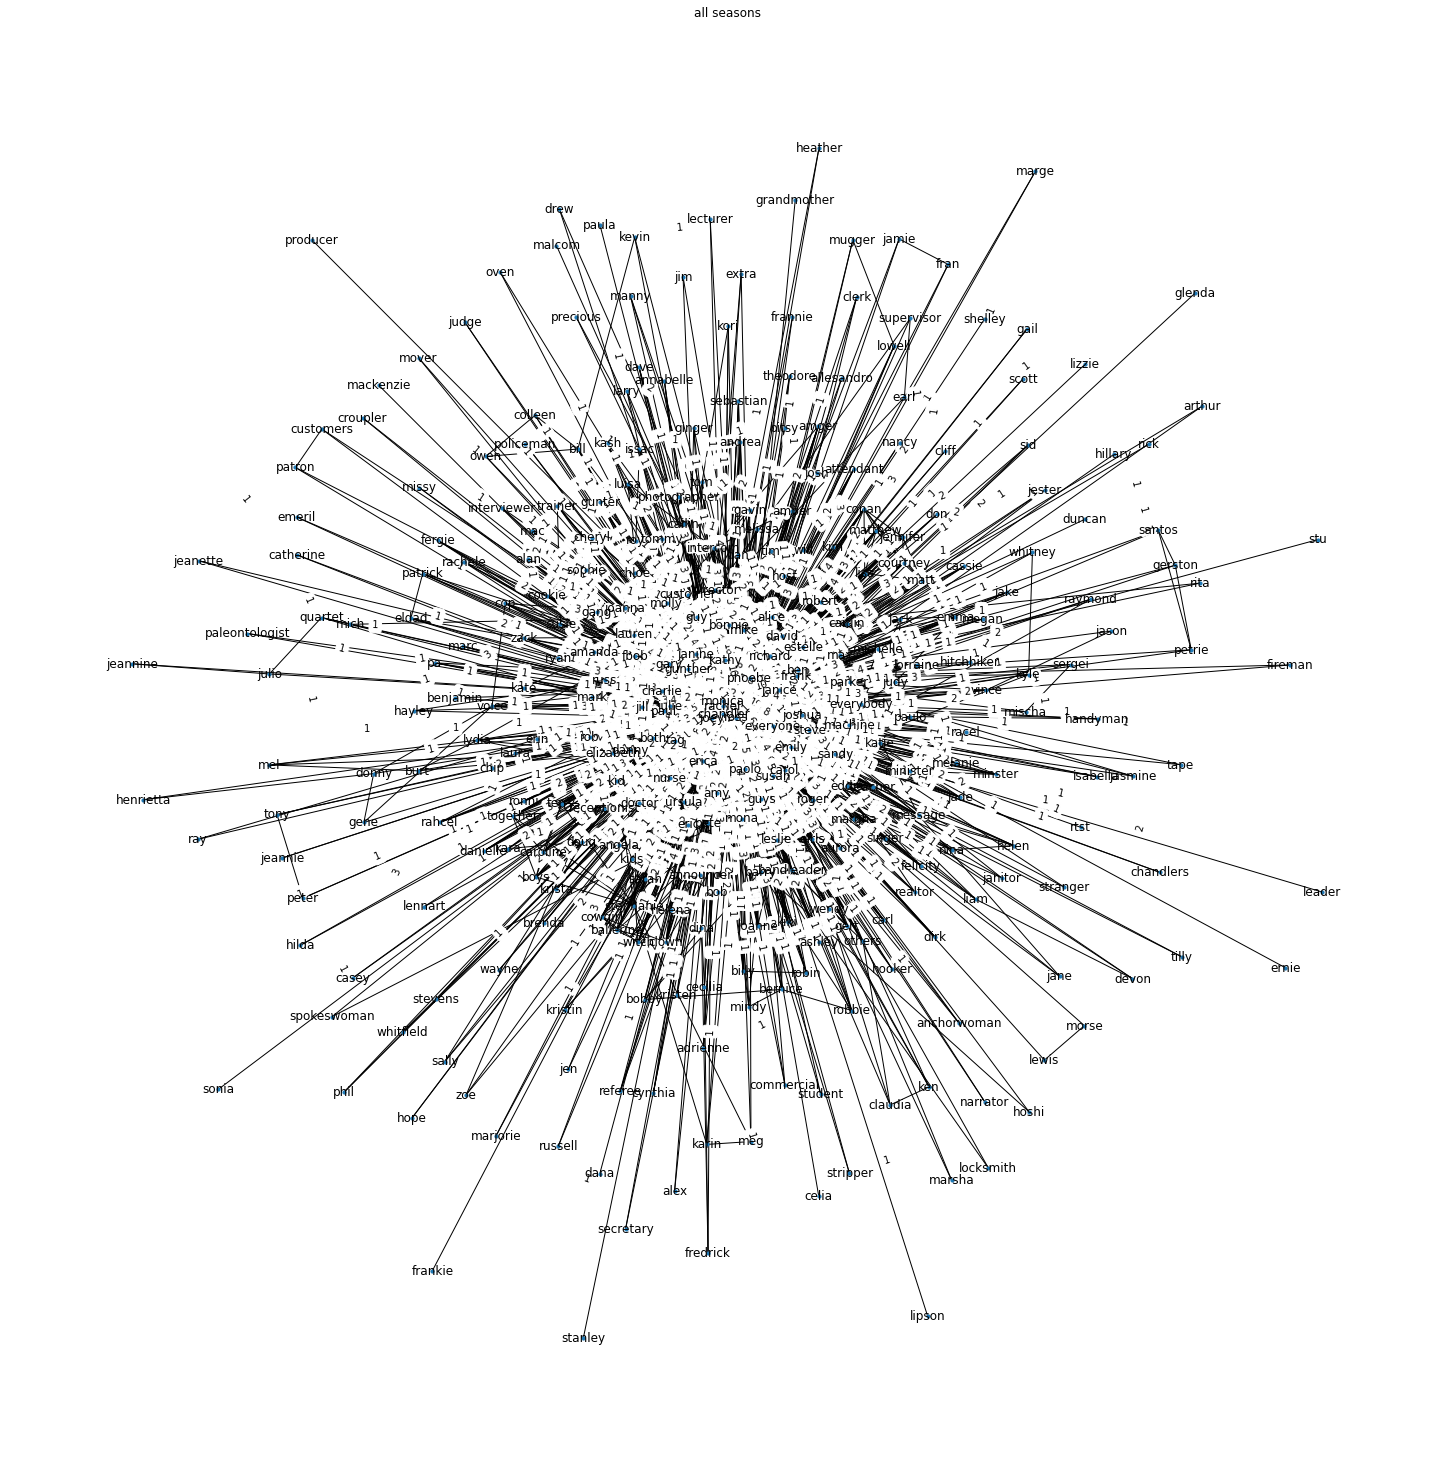

In [358]:
##creates the linkdata dataframe which we use to create the graph with the weight added as each edge's attribute
linkData = pd.DataFrame({'source' : intersection_df['node1'],
                  'target' : intersection_df['node2'],
                  'weight' : intersection_df['weight']})
G_S1 = nx.from_pandas_edgelist(linkData, 'source', 'target', True, nx.Graph())

##removes isolated nodes and random words
G_S1.remove_nodes_from(list(nx.isolates(G_S1)))
random_words_list=['waitress','actor','woman','man','actress','street','waiter','assistant','passenger',
                   'girl','boy','video','tv','radio', 'salesman', 'waiters','housekeeper','dog',
                  'boss','intern','cashier','chandlerdlers','passerby','friend','employee','lady','dream monica','dream joey','all']
G_S1.remove_nodes_from(random_words_list)

##plots the Graph
plt.figure(3,figsize=(20,20)) 
pos=nx.spring_layout(G_S1)
labels = nx.get_edge_attributes(G_S1,'weight')
nx.draw(G_S1,with_labels=True,node_size = 10)
nx.draw_networkx_edge_labels(G_S1,pos,edge_labels=labels)
plt.title('all seasons')

In [359]:
#creates txt file with the edgelist and their weights
nx.write_edgelist(G_S1, "weighted_test_edgelist.txt", delimiter=' ')

In [360]:
G_S1.number_of_nodes()
G_S1.number_of_edges()
print (f'The number of nodes is { G_S1.number_of_nodes()} \nThe number of links is {G_S1.number_of_edges()}')

The number of nodes is 330 
The number of links is 1560


The median of the in degrees is 5


/var/folders/3f/gy6lrkwn0c19wnb7_h2c682c0000gr/T/ipykernel_72127/1781827516.py:23: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "go-" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(range(len(degree_freq)), degree_freq, 'go-', label='degree', marker='.')


Text(0, 0.5, 'Frequency')

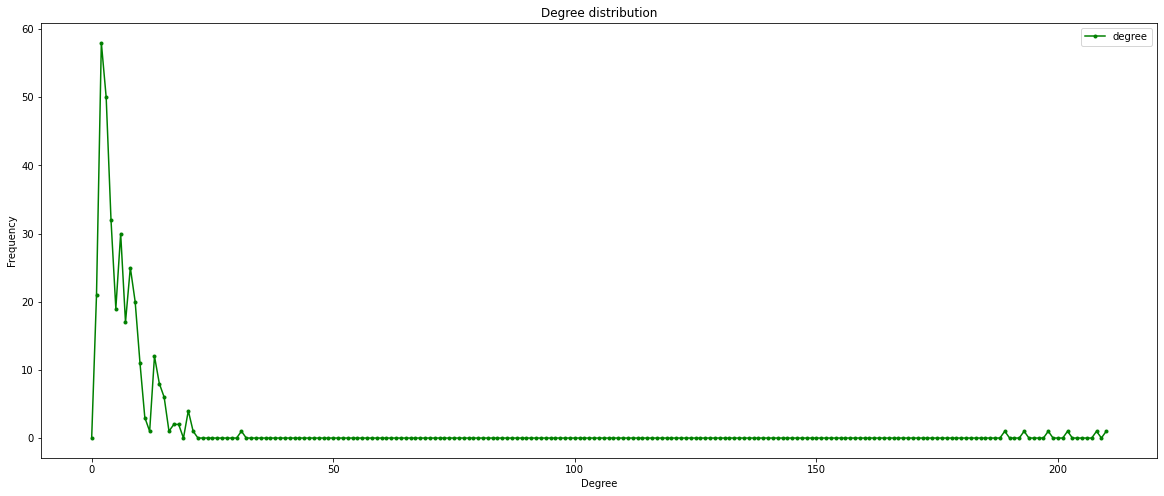

In [361]:
##Finds degree distibution
nodeslist=list(G_S1.nodes())
degrees=list(G_S1.degree(nodeslist))
# Sorts the in-degree matrix from low to high
deg=[]
for i in range (len(degrees)):
    deg.append(degrees[i][1])
list.sort(deg)
print (f'The median of the in degrees is {deg[int(len(deg)/2)]}')

def finds_freq(list1):
    dmax=max(list1)+1
    freq= [ 0 for d in range(dmax) ]
    for d in list1:
        freq[d] += 1
    return freq
degree_freq=finds_freq(deg)



degrees = range(len(degree_freq))
plt.figure(figsize=(20, 8)) 
plt.plot(range(len(degree_freq)), degree_freq, 'go-', label='degree', marker='.') 
plt.title("Degree distribution")
plt.legend(loc="upper right")
plt.xlabel('Degree')
plt.ylabel('Frequency')

In [362]:
   
# Using the degree of every node for custom sizing
degree=list(G_S1.degree())
# converts list of tuple to list of lists
res = [list(ele) for ele in degree]
custom_size=[]
for i in range(len(degree)):
    custom_size.append(res[i][1]*10)

100%|████████████████████████████████████| 2000/2000 [00:03<00:00, 597.38it/s]


BarnesHut Approximation  took  0.88  seconds
Repulsion forces  took  2.00  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.15  seconds
AdjustSpeedAndApplyForces step  took  0.15  seconds


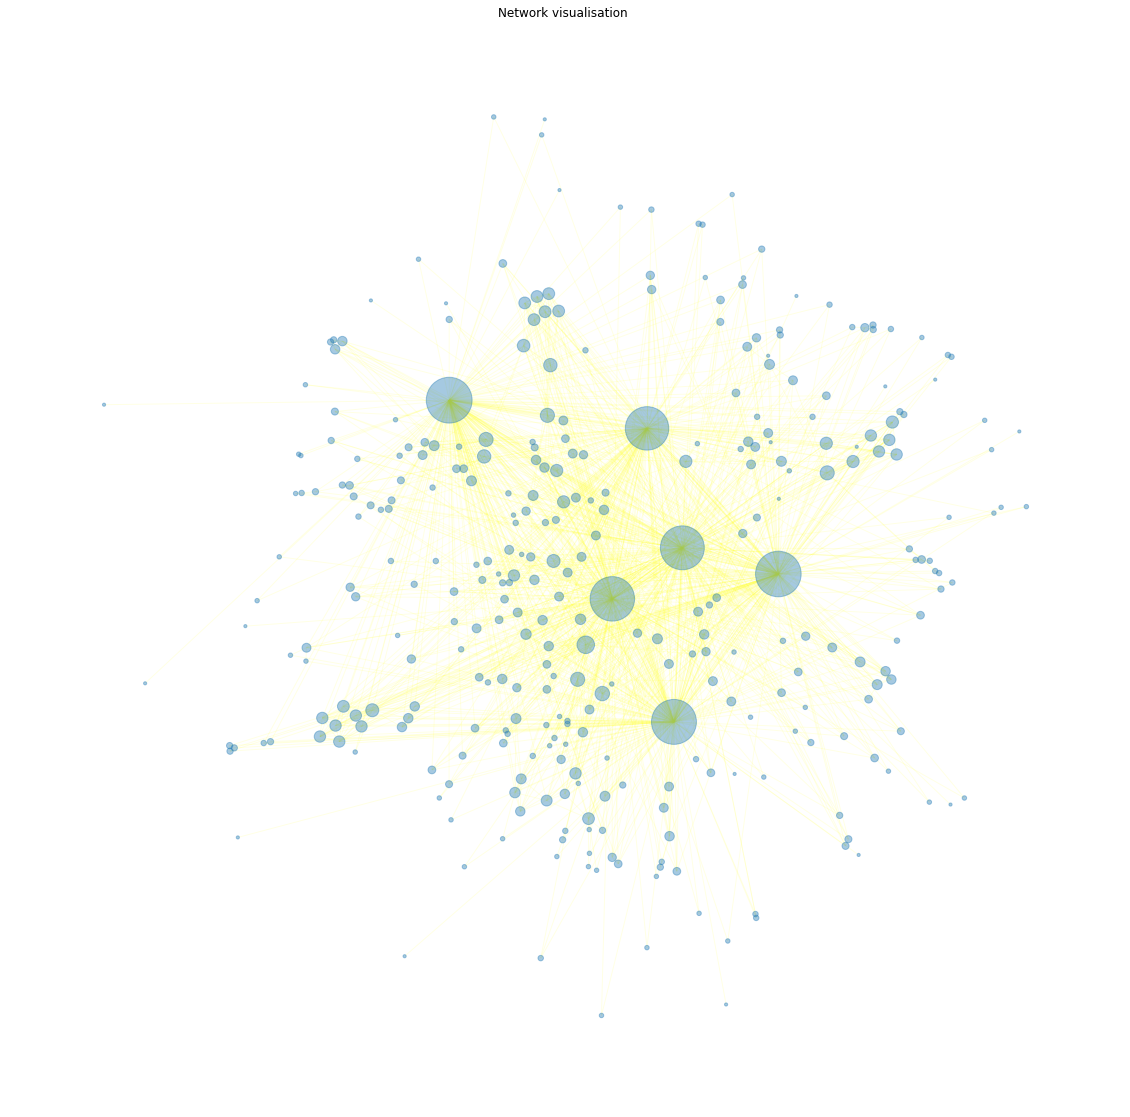

In [363]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  
                        edgeWeightInfluence=0.5,

                        # Performance
                        jitterTolerance=0.1,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,

                        # Tuning
                        scalingRatio=1.0,
                        strongGravityMode=False,
                        gravity=0.7,

                        # Log
                        verbose=True)

fig, ax = plt.subplots(figsize=(20,20))
positions = forceatlas2.forceatlas2_networkx_layout(G_S1, pos=None, iterations=2000)
nx.draw_networkx_nodes(G_S1, positions,ax=ax, node_size=custom_size, alpha=0.4)
nx.draw_networkx_edges(G_S1, positions,ax=ax, edge_color="yellow", alpha=0.1)
plt.title('Network visualisation ')
plt.axis('off')
plt.show()

In [364]:
# First compute the best partition
partition = community.community_louvain.best_partition(G_S1,weight='weight')


size =len(set(partition.values()))

# Find number of communities and print each one's size
print(f'The friends network has {int(size)} communities')

comm_sizes=Counter(partition.values())
community_sizes_list=list(comm_sizes.values())
community_sizes_list.sort()
for i in range (len(community_sizes_list)):
    print(f'Community {i} has size {community_sizes_list[i]}')

# Add 'community' attribute to node 
nx.set_node_attributes(G_S1, partition, name= 'community')

The friends network has 18 communities
Community 0 has size 2
Community 1 has size 2
Community 2 has size 2
Community 3 has size 2
Community 4 has size 2
Community 5 has size 3
Community 6 has size 4
Community 7 has size 4
Community 8 has size 6
Community 9 has size 6
Community 10 has size 15
Community 11 has size 18
Community 12 has size 18
Community 13 has size 20
Community 14 has size 24
Community 15 has size 27
Community 16 has size 42
Community 17 has size 133


In [365]:
color_dictionary={0:'deeppink',
                  1:'purple',
                  2: 'aquamarine',
                  3:'red',
                  4:'blue',
                  5:'orange',
                  6:'coral',
                  7:'green',
                  8:'brown',
                  9:'peachpuff',
                  10:'black',
                  11:'pink',
                  12:'wheat',
                  13:'gray',
                  14:'lightcoral',
                  15:'beige',
                  16:'indigo',
                  17:'lightgreen',
                  18:'indigo',
                  19:'lightgreen',
                  20:'indigo',
                  21:'lightgreen'}

# Creates color list and size list for all the nodes
# Using the 'community' attribute for coloring
community=nx.get_node_attributes(G_S1, 'community')  
nodeslist=list(G_S1.nodes())
custom_color=[]
for i in nodeslist:
    custom_color.append(color_dictionary[community[i]])
    
# Using the degree of every node for custom sizing
degree=list(G_S1.degree())
# Converts list of tuple to list of lists
res = [list(ele) for ele in degree]
custom_size=[]
for i in range(len(degree)):
    custom_size.append(res[i][1]*10)


100%|████████████████████████████████████| 2000/2000 [00:03<00:00, 626.29it/s]


BarnesHut Approximation  took  0.87  seconds
Repulsion forces  took  1.86  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.15  seconds
AdjustSpeedAndApplyForces step  took  0.15  seconds


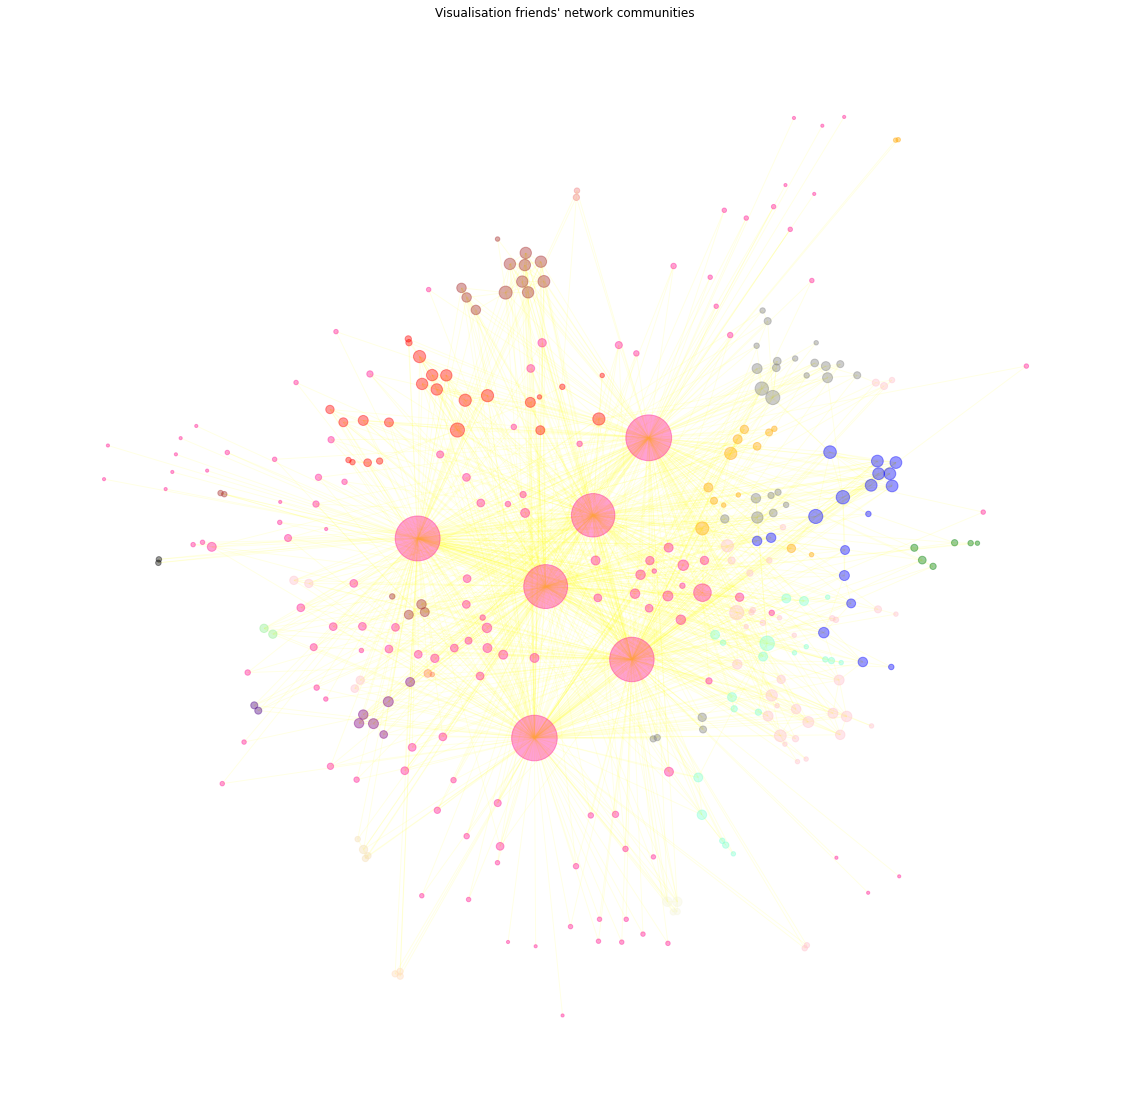

In [366]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  
                        edgeWeightInfluence=0.5,

                        # Performance
                        jitterTolerance=0.5,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,

                        # Tuning
                        scalingRatio=10,
                        strongGravityMode=False,
                        gravity=0,

                        # Log
                        verbose=True)


fig, ax = plt.subplots(figsize=(20,20))
positions = forceatlas2.forceatlas2_networkx_layout(G_S1, pos=None, iterations=2000)
nx.draw_networkx_nodes(G_S1, positions,ax=ax, node_color=custom_color, node_size=custom_size, label=nodeslist, alpha=0.4)
nx.draw_networkx_edges(G_S1, positions,ax=ax, edge_color="yellow", alpha=0.1)
plt.title("Visualisation friends' network communities")
plt.axis('off')
plt.show()

-------------------------------------------------
# Sentiment Analysis

In [367]:
# creates a dictionary with the LabMT data we need

with open('LabMIT.txt') as f:
        lines = f.readlines()
lines=lines[4:]

LabMT_dict = {}
for line in lines:
    word_full_data=line.split('\t')
    LabMT_dict [word_full_data[0]] = word_full_data[2]

In [368]:
LabMT_df = pd.DataFrame.from_dict(LabMT_dict, orient='index')
LabMT_df.head()

,0
laughter,8.50
happiness,8.44
love,8.42
happy,8.30
laughed,8.26


In [369]:
def sentiment_analyzer(str_input):
    clean_text= word_tokenize(str_input)
    sentimentsum=0
    wordsum=0
    for i in range (len(clean_text)):
        for key in LabMT_dict.keys():
            if clean_text[i]==key:
                wordsum=wordsum+1
                sentimentsum=sentimentsum+float(LabMT_dict[key])
    wikitext_sentiment=sentimentsum/(wordsum+1)
    return wikitext_sentiment
    print(wikitext_sentiment)

--------------------

### Sentiment Analysis by character

### Sentiment analysis of the 15 most famous characters

In [370]:
# Dataframe with all the characters and their text
characters_words_df = pd.read_csv('each_characters_lines_all_seasons.csv', header= 0,
                        encoding= 'utf-8')
characters_words_df =characters_words_df.drop(['Comm-Count'], axis=1)

Calculating sentiment function

In [371]:
characters_words_dict = dict(characters_words_df.values)

Calculating & visualizing sentiment for the 15 most loved characters

In [372]:
sentiment_dict={}
character_list_for_sentiment = ['chandler', 'monica', 'rachel', 'ross', 'phoebe', 'joey', 'janice','janine','carol', 'mark','mike','estelle','richard', 'gary']
for i in range(len(character_list_for_sentiment)):
    key=character_list_for_sentiment[i]
    sentiment_dict[key]=sentiment_analyzer(characters_words_dict[key])

In [373]:
sentiment_df= pd.DataFrame([sentiment_dict])

In [374]:
sentiment_df
sentiment_df=sentiment_df.transpose()
sentiment_df.reset_index(inplace=True)
sentiment_df = sentiment_df.rename(columns = {'index':'Character'})
sentiment_df = sentiment_df.rename(columns = {0:'Score'})

In [375]:
sentiment_df

,Character,Score
0,chandler,5.593654
1,monica,5.597526
2,rachel,5.584040
3,ross,5.592245
4,phoebe,5.605857
5,joey,5.590904
6,janice,5.630039
7,janine,5.578815
8,carol,5.646745
9,mark,5.634795


[Text(0.5, 1.0, 'Best Characters sentiment'), (5.45, 5.7)]

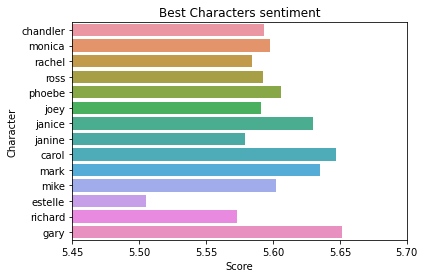

In [376]:
sb.barplot(x = "Score", y= "Character", data = sentiment_df).set(title = "Best Characters sentiment",xlim=(5.45,5.7))

### Sentiment Analysis of all characters (biggest community)

Calculating sentiment and visualising histogram of all characters

In [377]:
characters_words_df[characters_words_df['text'].isnull()]

,character,text
48,extra,NaN


In [378]:
characters_words_df=characters_words_df.dropna()
characters_words_df=characters_words_df.dropna(axis=0)
characters_words_df[characters_words_df['text'].isnull()]
characters_words_df= characters_words_df.reset_index(drop=True)
characters_words_df.head(50)

,character,text
0,chandler,right joey nice hump hump hairpiece sounds lik...
1,attendant,scolding nno running chapel
2,tag,thats thats whole name know havent worked offi...
3,hilda,thats right dear thank good meeting
4,mac,tv well learned one thing today cheese cheerle...
5,narrator,cretaceous period ended dinosaurs gone
6,wayne,cheese right puts headset picks controller whe...
7,sebastian,hi get cup coffee go hands cup sure uh really ...
8,dana,yknow ran school howie apparently howies editi...
9,hillary,could except become chef someday soon hope ope...


In [379]:
characters_words_dict = dict(characters_words_df.values)

In [380]:
sentiment_analyzer(characters_words_dict['michelle'])

5.357916666666667

In [382]:
sentiment_dict_all={}
for i in range (len(characters_words_dict)):
    key=characters_words_df['character'][i]
    sentiment_dict_all[key]=sentiment_analyzer(characters_words_dict[key])

The mean value of sentiment is 5.241239208692791
the 10th percentile sentiment values is 4.622352941176469
the 90th percentile sentiment values is 5.705249343832017


<Figure size 432x288 with 0 Axes>

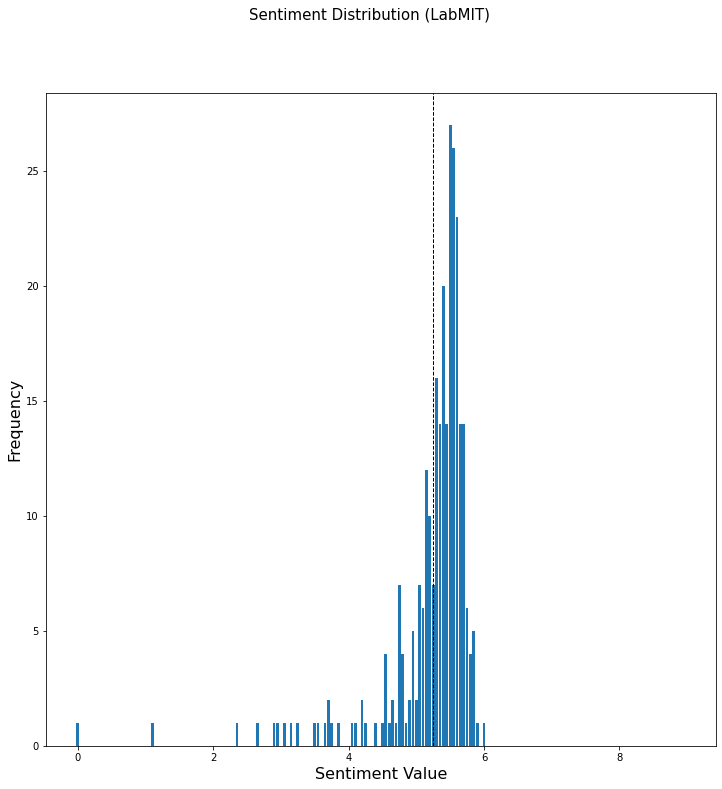

In [383]:
sentiment_sequence=list(sentiment_dict_all.values())
print(f'The mean value of sentiment is {statistics.mean(sentiment_sequence)}')
#We calculate a sorted version of the character sentiment dictionary to help in finding top happiest and saddest
sentiment_sorted=dict(sorted(sentiment_dict_all.items(), key=lambda item: item[1]))

keys1=list(sentiment_sorted.keys())
print(f'the 10th percentile sentiment values is {sentiment_sorted[keys1[int(len(sentiment_dict_all)*0.1)]]}')
print(f'the 90th percentile sentiment values is {sentiment_sorted[keys1[int(len(sentiment_dict_all)*0.9)]]}')

maximum=list(sentiment_sorted.values())[-1]
minimum=list(sentiment_sorted.values())[0]

b = np.array(np.arange(minimum,maximum+3,0.05))
hist,bins = np.histogram(list(sentiment_sorted.values()),b)

fig = plt.figure()
fig, ax = plt.subplots(figsize=(12,12))
bar = plt.bar(b[:-1],hist,width=0.04)
plt.axvline(statistics.mean(sentiment_sequence), color='k', linestyle='dashed', linewidth=1)

fig.suptitle('Sentiment Distribution (LabMIT)', fontsize=15)
plt.xlabel('Sentiment Value', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.show()

## Sentiment analysis by season

In [522]:
# Dataframe with all the characters and their text
season_words_df = pd.read_csv('season_cleaned.csv', header= 0,
                        encoding= 'utf-8')
season_words_df = season_words_df.drop(season_words_df.columns[[0]], axis=1)


In [523]:
season_words_df

,season,text
0,1,central perk chandler joey phoebe monica there...
1,2,central perk phoebe recapping last season talk...
2,3,rachel monicas phoebe ross rachel eating break...
3,4,beach house scene end last year ross front two...
4,5,rosss wedding continued last season minister m...
5,6,wedding chapel continued last season chandler ...
6,7,monica chandler phoebes chandler joey rachel p...
7,8,wedding hall monica chandler said photographer...
8,9,rachels room joey moves rosss coat get tissues...
9,10,barbados monica chandlers room enter rosss roo...


In [524]:
season_words_dict = dict(season_words_df.values)

In [525]:
sentiment_dict_season={}
for i in range (len(season_words_dict)):
    key=season_words_df['season'][i]
    sentiment_dict_season[key]=sentiment_analyzer(season_words_dict[key])
    print(i, key, sentiment_dict_season[key])

0 1 5.590884873515652
1 2 5.594984847931579
2 3 5.585476920302876
3 4 5.6175830746609385
4 5 5.604876833396009
5 6 5.5997535221712065
6 7 5.642389048015007
7 8 5.622765072765051
8 9 5.601037429746864
9 10 5.6226601371202705


In [526]:
season_sentiment_df= pd.DataFrame([sentiment_dict_season])
season_sentiment_df=season_sentiment_df.transpose()
season_sentiment_df.reset_index(inplace=True)
season_sentiment_df = season_sentiment_df.rename(columns = {'index':'Season'})
season_sentiment_df = season_sentiment_df.rename(columns = {0:'Score'})
season_sentiment_df.head(10)

,Season,Score
0,1,5.590885
1,2,5.594985
2,3,5.585477
3,4,5.617583
4,5,5.604877
5,6,5.599754
6,7,5.642389
7,8,5.622765
8,9,5.601037
9,10,5.622660


In [527]:
type(season_sentiment_df['Season'][0])
import string
season_sentiment_df['Season']=season_sentiment_df['Season'].map(str)
type(season_sentiment_df['Season'][0])

str

[Text(0.5, 1.0, 'Seasons sentiment'), (5.55, 5.65)]

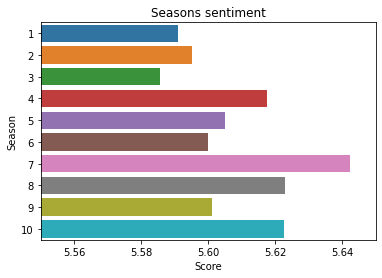

In [528]:
sb.barplot(x = "Score", y= "Season", data = season_sentiment_df).set(title = "Seasons sentiment",xlim=(5.55,5.65))

The mean value of sentiment is 5.6082411759625455
the minimum sentiment values is 5.585476920302876
the maximum sentiment values is 5.642389048015007


<Figure size 432x288 with 0 Axes>

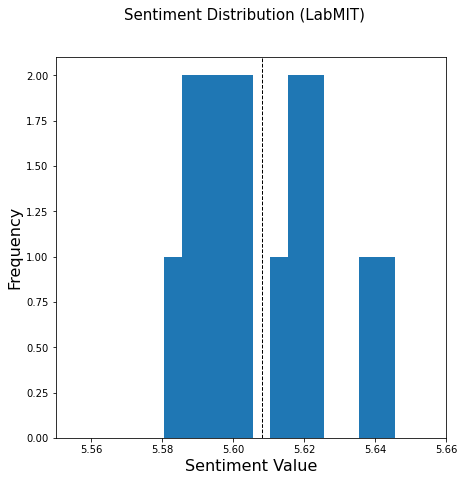

In [530]:
sentiment_sequence=list(sentiment_dict_season.values())
print(f'The mean value of sentiment is {statistics.mean(sentiment_sequence)}')

sentiment_sorted=dict(sorted(sentiment_dict_season.items(), key=lambda item: item[1]))

keys1=list(sentiment_sorted.keys())

maximum=list(sentiment_sorted.values())[-1]
minimum=list(sentiment_sorted.values())[0]
print(f'the minimum sentiment values is {minimum}')
print(f'the maximum sentiment values is {maximum}')

b = np.array(np.arange(minimum,maximum+2,0.005))
hist,bins = np.histogram(list(sentiment_sorted.values()),b)

fig = plt.figure()
fig, ax = plt.subplots(figsize=(7,7))
bar = plt.bar(b[:-1],hist,width=0.01)
plt.axvline(statistics.mean(sentiment_sequence), color='k', linestyle='dashed', linewidth=1)

fig.suptitle('Sentiment Distribution (LabMIT)', fontsize=15)
plt.xlabel('Sentiment Value', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.xlim(xmin=5.55, xmax = 5.66)
plt.show()

----------------------------------
# NLPP

dispersion plot between the main characters to see their relation in seasons

In [426]:
import nltk
from nltk import Text, word_tokenize

In [531]:
# convert str to txt
season_words_df['tokenized_text']= season_words_df['text'].apply(lambda x:Text(word_tokenize(x)))

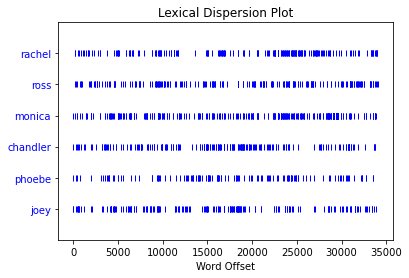

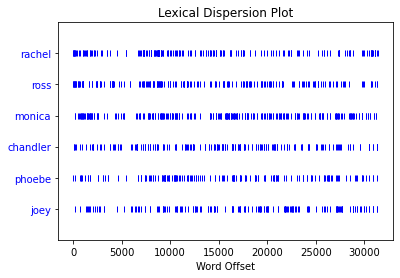

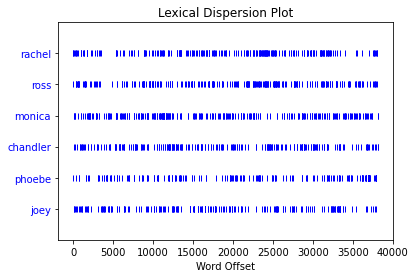

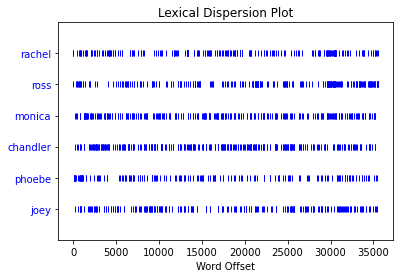

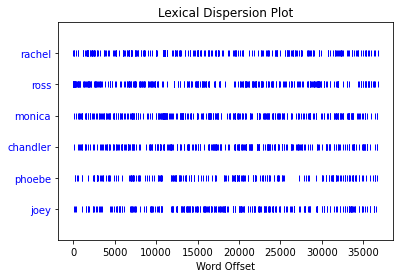

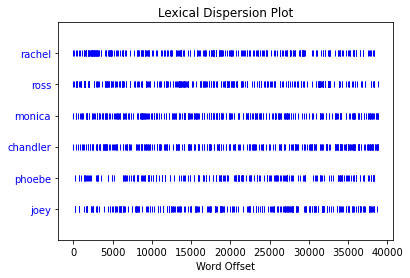

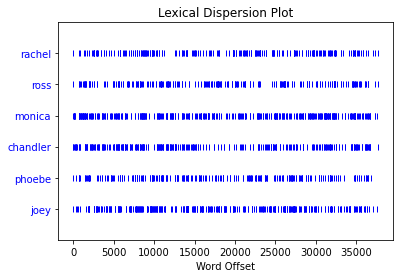

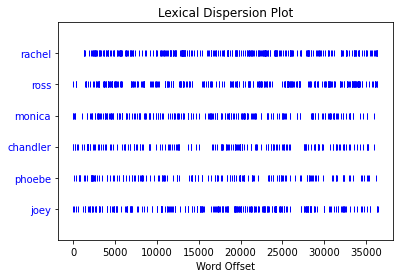

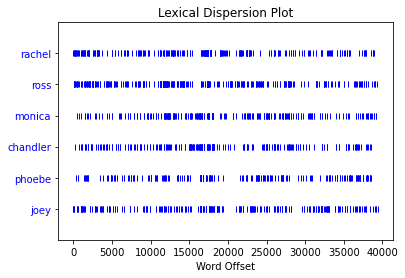

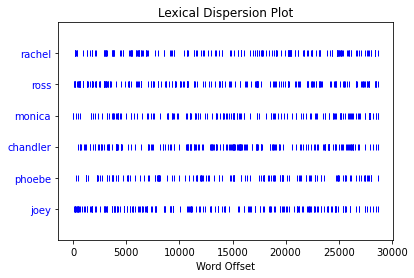

0    None
1    None
2    None
3    None
4    None
5    None
6    None
7    None
8    None
9    None
Name: tokenized_text, dtype: object

In [532]:
season_words_df['tokenized_text'].apply(lambda x: x.dispersion_plot([ 'rachel', 'ross', 'monica','chandler','phoebe', 'joey']))

In [533]:
# Graph for the most common words of all seasons
all_words = []
for i in range(len(season_words_df['text'])):
    all_words.append(season_words_df['text'][i])

# it is already tokenized (?)
all_words_txt= ''.join(all_words)
all_words_txt= Text(word_tokenize(all_words_txt))

In [534]:
fdist2 = nltk.FreqDist(all_words_txt)
fdist2.most_common(20)

[('oh', 7662),
 ('im', 5868),
 ('yeah', 4853),
 ('okay', 4840),
 ('know', 4766),
 ('well', 4411),
 ('dont', 4240),
 ('hey', 3906),
 ('na', 3610),
 ('right', 3454),
 ('like', 3112),
 ('get', 2879),
 ('gon', 2850),
 ('youre', 2788),
 ('monica', 2722),
 ('ross', 2661),
 ('thats', 2636),
 ('really', 2520),
 ('go', 2497),
 ('chandler', 2454)]

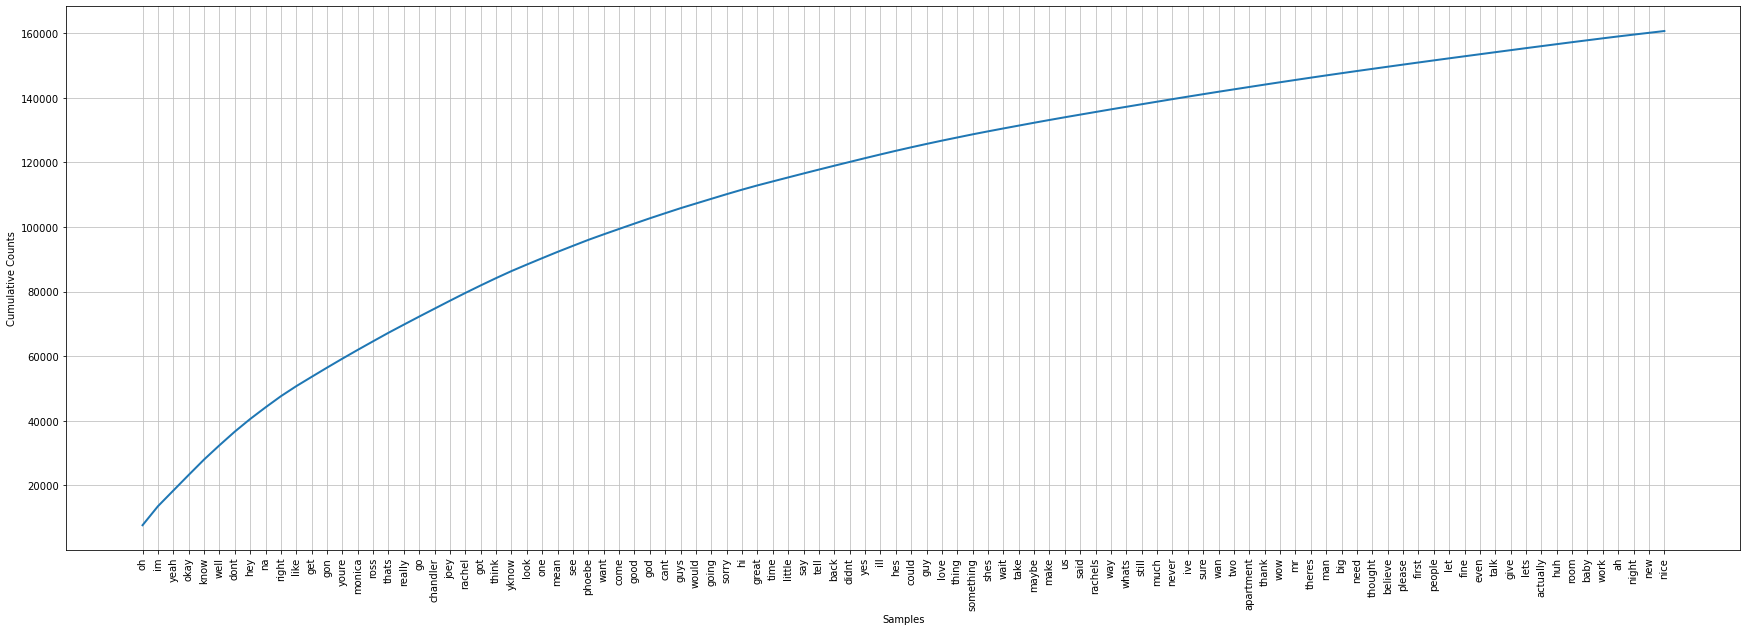

<AxesSubplot:xlabel='Samples', ylabel='Cumulative Counts'>

In [535]:
f = plt.figure(figsize=(30,10))
fdist2.plot(100, cumulative= True)

Read in the texts OUR corpus reader. Count occurrences of MOST USED WORDS in each document. What has happened to the usage of these words over time?

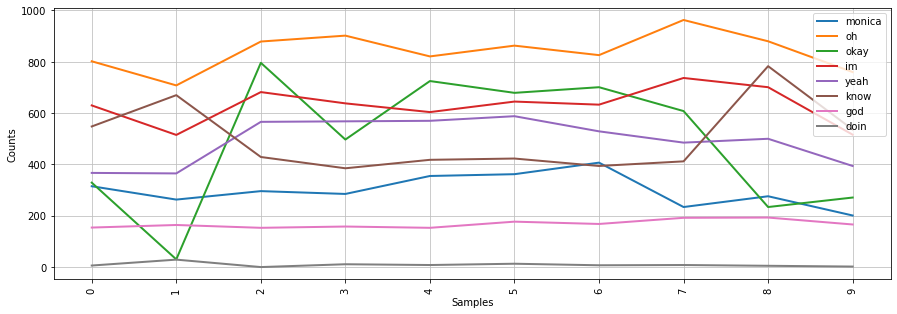

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [550]:
from nltk import ConditionalFreqDist
cfd = nltk.ConditionalFreqDist(
  (target, fileid)
  for fileid in range(len(season_words_df['season']))
  for w in season_words_df['tokenized_text'][fileid]
  for target in ['oh','im', 'yeah', 'monica', 'know','god', 'okay', 'doin']
  if w.lower().startswith(target))
k = plt.figure(figsize=(15,5))
cfd.plot()

#### EX.23 Zipf's Law: 
Let f(w) be the frequency of a word w in free text. Suppose that all the words of a text are ranked according to their frequency, with the most frequent word first. Zipf's law states that the frequency of a word type is inversely proportional to its rank (i.e. f × r = k, for some constant k). For example, the 50th most common word type should occur three times as frequently as the 150th most common word type.  
       a. Write a function to process a large text and plot word frequency against word rank using pylab.plot. Do you confirm Zipf's law? (Hint: it helps to use a logarithmic scale). What is going on at the extreme ends of the plotted line?  
       b. Generate random text, e.g., using random.choice("abcdefg "), taking care to include the space character. You will need to import random first. Use the string concatenation operator to accumulate characters into a (very) long string. Then tokenize this string, and generate the Zipf plot as before, and compare the two plots. What do you make of Zipf's Law in the light of this?

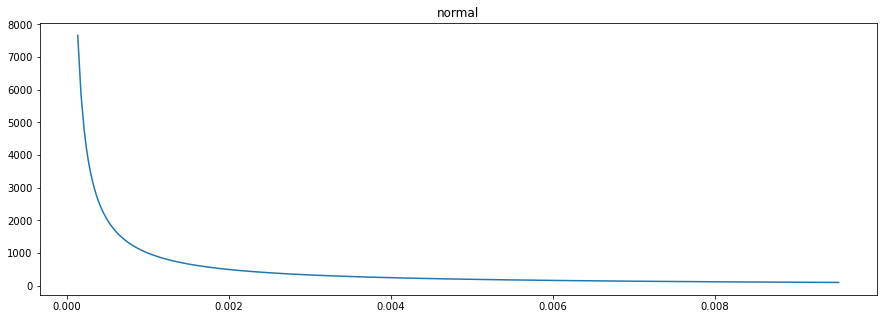

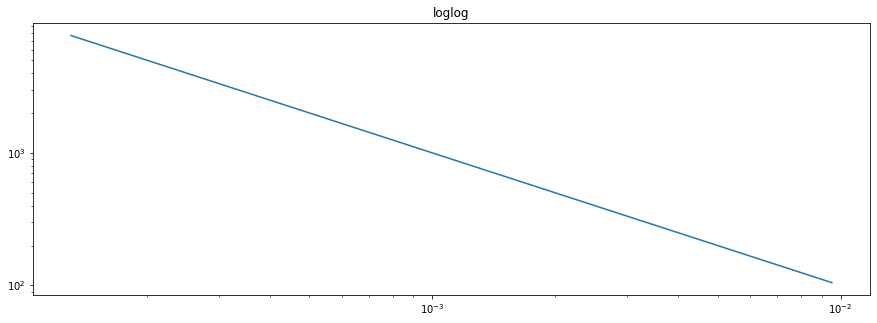

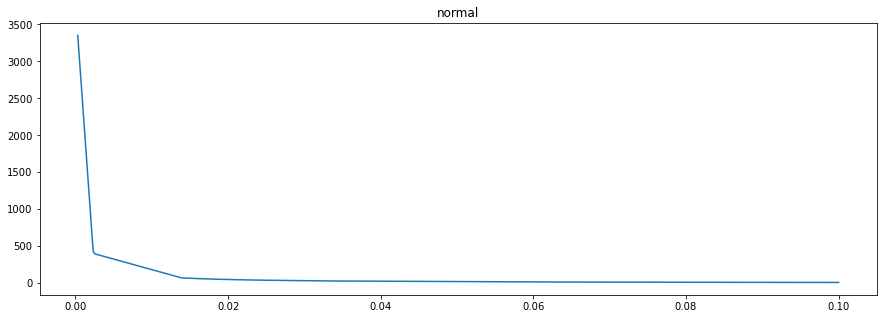

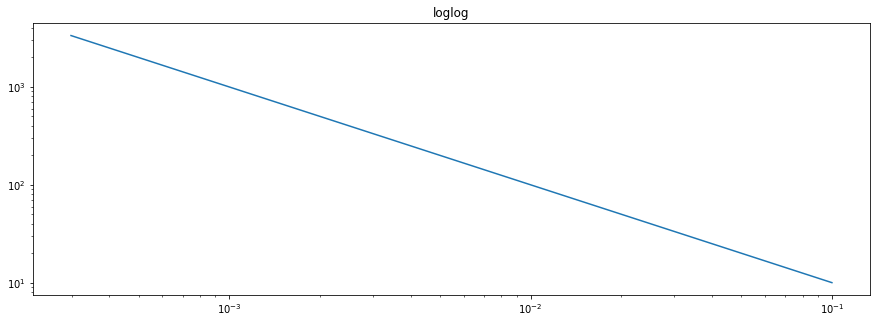

In [557]:
import random
def zipfs_law(text,n):
    text_fd=nltk.FreqDist(text)
    text_fd_common=text_fd.most_common(n)
    freqs=[y for x,y in text_fd_common]
    ranks=[1/freq for freq in freqs]
    
    plt.figure(figsize=(15,5))
    plt.plot(ranks,freqs)
    plt.title("normal")        
    plt.figure(figsize=(15,5))
    plt.loglog(ranks,freqs)
    plt.title("loglog")

zipfs_law(all_words_txt,500)

#looks inversely proportional but is the solution correct??

# Generate random text, e.g., using random.choice("abcdefg "), 
#taking care to include the space character. You will need to import random first. 
#Use the string concatenation operator to accumulate characters into a (very) long string. 
#Then tokenize this string, and generate the Zipf plot as before, 
# and compare the two plots. What do you make of Zipf's Law in the light of this?

random_text=''
for i in range(0,random.randrange(10000,1000000)):
    random_text+=random.choice("abcdefg ")
# print(random_text)
zipfs_law(random_text.split(' '),100)
#yes it is almost inversely proportion